/usr/local/lib/python3.7/dist-packages/scipy/optimize/minpack.py:808: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


current timestep: 10
current timestep: 20
current timestep: 30
current timestep: 40
current timestep: 50


/usr/local/lib/python3.7/dist-packages/scipy/optimize/minpack.py:808: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


current timestep: 10
current timestep: 20
current timestep: 30
current timestep: 40
current timestep: 50


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:229: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


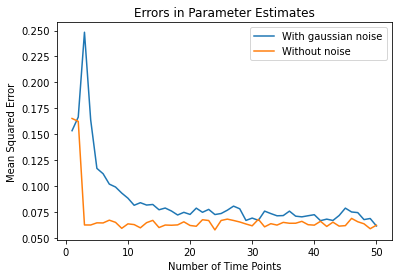

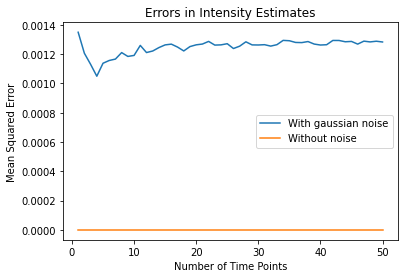

In [25]:
# Author: Hannah
# 5/27/22
# Simulates a grid of particles and fits a least squares model

import numpy as np
from scipy.optimize import curve_fit
import matplotlib.pyplot as plt
from skimage.filters import gaussian

np.random.seed(3) # set seed during development and testing of code

# constants
GRID_LENGTH = 20
NUM_SOURCE_1 = 10
NUM_SOURCE_2 = 10

TIME_RANGE = 50
TAU_RANGE = 10
# TIME_INTERVAL = 1   #how many ns per timestep
# NUM_TIMESTEPS = int(round(TIME_RANGE / TIME_INTERVAL))
TIMESTEP_START = 1
TIMESTEP_ARRAY = np.arange(TIMESTEP_START, TIME_RANGE + 1)
HEAVISIDE_START = 10
HEAVISIDE_LENGTH = 20   #in ns

TAU_1 = TAU_RANGE * np.random.random()
TAU_2 = TAU_RANGE * np.random.random()
SAMPLING_FACTOR = 2

NOISE_MEAN = 0.02
NOISE_SPREAD = 0.03
BLUR = 0.5

# performs convolution
def conv(a,b):
    A = np.fft.fft(a)
    B = np.fft.fft(b)
    C = A * B
    return abs(np.fft.ifft(C)/np.sum(a))

# performs deconvolution
def deconv(a,b):
    A = np.fft.fft(a)
    B = np.fft.fft(b)
    return abs(np.fft.ifft(A/B))

# given parameter estimates, finds intensity value before convolution
def multiexp(t, a1, a2):
  return a1 * np.exp(-(t - HEAVISIDE_START) / TAU_1) + a2 * np.exp(-(t - HEAVISIDE_START) / TAU_2)

def add_poisson_noise(decay):
  # Signal dependent noise (shot noise)
  #plt.plot(decay)
  decay = decay + np.random.poisson(decay)
  #plt.plot(decay)
  #plt.show()
  return (decay)

def add_gaussian_noise(t, decay, noise_mean, noise_spread):
  # Read noise from electronics
  # In general use same parameteres in entire image
  # Start with small values
  # fig2 = plt.figure()
  # ax2 = fig2.add_subplot()
  # ax2.set_xlabel('Time (ns)')
  # ax2.set_ylabel('Intensity')
  # ax2.set_title('Pixel Intensity with Read Noise')
  # plt.plot(t, decay, label="Actual intensity")
  decay = decay + np.random.normal(noise_mean, noise_spread, size=t.shape)
  # plt.plot(t, decay, label="Noised intensity")
  # ax2.legend()
  # plt.show()
  return (decay)

# function to simulate with random noise
def simulation_function(inputs, a1, a2, add_noise):
  t = inputs[:,0]
  guess = multiexp(t, a1, a2)
  guess = conv(guess, inputs[:,1])
  # guess = add_poisson_noise(guess)
  if (add_noise):
    guess = add_gaussian_noise(t, guess, NOISE_MEAN, NOISE_SPREAD)
  return guess

# combined function of exponential and convolution that produces intensities
def function(inputs, a1, a2):
  guess = multiexp(inputs[:,0], a1, a2)
  return conv(guess, inputs[:,1])
  
# uses nonlinear least squares to fit parameters to the function
def nonlin_least_squares(method, inputs, I):
  init_a = np.random.rand(2)
  params = curve_fit(function, inputs, I, p0=init_a, method=method, bounds=(0, 1), verbose=0)
  return params

# creates data points for the heaviside irf
def heaviside_irf(t, irf_start):
    irf = np.zeros(len(t))
    #print(len(t))
    irf_start = int(irf_start *  len(t) / TIME_RANGE)
    irf_length = int(HEAVISIDE_LENGTH * len(t) /  TIME_RANGE )
    #print(irf_start)
    #print(irf_length)
    irf[irf_start:irf_start+irf_length] = 1
    return irf

# randomly creates parameters for a grid
def create_params_grid():
    params = np.zeros((GRID_LENGTH, GRID_LENGTH, 2))
    # # insert sources of type 1
    # for i in range(NUM_SOURCE_1):
    #   value = np.random.random()
    #   params[np.random.randint(GRID_LENGTH), np.random.randint(GRID_LENGTH), 0] = value
    # # insert sources of type 2
    # for i in range(NUM_SOURCE_2):
    #   value = np.random.random()
    #   params[np.random.randint(GRID_LENGTH), np.random.randint(GRID_LENGTH), 1] = value

    # or insert sources everywhere
    for row in range(GRID_LENGTH):
      for column in range(GRID_LENGTH):
        value1 = np.random.random()
        params[row, column, 0] = value1
        value2 = np.random.random()
        # value2 = 1 - value1
        params[row, column, 1] = value2

    # print("actual ratio", params[:,:,0] / params[:,:,1])
    return params

# creates intensities grid
def create_pixel_grid(irf_start, params, timesteps, add_noise):
    # calculate intensities
    t_values = np.linspace(0, TIME_RANGE, timesteps)
    IRF = heaviside_irf(t_values, irf_start)
    inputs = np.stack((t_values, IRF), axis=1)
    intensities = np.zeros((GRID_LENGTH, GRID_LENGTH, timesteps))
    for row in range(GRID_LENGTH):
      for column in range(GRID_LENGTH):
        if (params[row, column, 0] == 0 and params[row, column, 1] == 0):
          intensities[row, column] = 0
        else:
          intensities[row, column] = simulation_function(inputs, params[row, column, 0], params[row, column, 1], add_noise)
    # apply gaussian blurring
    # blurred = np.zeros(intensities.shape)
    # for t in range(timesteps):
    #   blurred[:,:,t] = gaussian(intensities[:,:,t], sigma=BLUR)
    blurred = intensities
    return (params, blurred)

def run_experiment(timesteps, params, add_noise=False):
  # modeling data
  t = np.linspace(0, TIME_RANGE, timesteps)
  irf_start = HEAVISIDE_START * (timesteps / TIME_RANGE)
  IRF = heaviside_irf(t, HEAVISIDE_START)
  inputs = np.stack((t, IRF), axis=1)

  (true_params, blurred) = create_pixel_grid(HEAVISIDE_START, params, timesteps, add_noise)
  true_ratios = true_params[:,:,0] / true_params[:,:,1]
  model = np.zeros((GRID_LENGTH, GRID_LENGTH, 2))
  est = np.zeros((GRID_LENGTH, GRID_LENGTH, timesteps))
  for row in range(GRID_LENGTH):
    for column in range(GRID_LENGTH):
      model[row, column] = nonlin_least_squares('trf', inputs, blurred[row, column])[0]
      # print("act", blurred[row,column])
      est[row,column] = function(inputs, model[row, column, 0], model[row, column, 1])
      # print("est", est[row,column])

  # print("found ratio", model[:,:,0] / model[:,:,1])
  # choose random pixel and print it
  randx = np.random.randint(GRID_LENGTH)
  randy = np.random.randint(GRID_LENGTH)
  rand_print = (randx, randy)
  # rand_model = nonlin_least_squares('trf', inputs, blurred[randx, randy])[0]
  # rand_est = function(inputs, model[randx, randy, 0], model[randx, randy, 1])
  # print(est[rand_print])
  # print(blurred[rand_print])
  # randx=1
  # randy=1
  # print("showing you pixel at", randx, randy)
  # plt.plot(blurred[randx, randy])
  # plt.plot(est[randx, randy])

  # calculate mse
  # print("running with", timesteps, "timesteps")
  fake_est = model[randx, randy]
  fake_mse = ((fake_est - true_params)**2).mean()
  # print("\nFake MSE", fake_mse)
  # print(model[randx, randy])
  model_ratios = model[:,:,0] / model[:,:,1]
  mse = ((est - blurred)**2).mean()
  # print("MSE in total intensity", mse, '\n')
  param_mse = (((model - true_params))**2).mean()
  # print(model_ratios)
  # print(true_ratios)
  # print("MSE for", timesteps, ":", param_mse, '\n')

  # plt.show()

  # if (timesteps == TIME_RANGE):  # print out grid
  #   picture = plt.figure()
  #   pic1 = picture.add_subplot()
  #   pic1.set_title('Simulated Fluorescent Grid')
  #   pic1.imshow(blurred[:, :, int(round(timesteps / 5))])
  #   plt.show()

  return (mse, param_mse)

def main():
  params = create_params_grid()
  errors = np.zeros(TIMESTEP_ARRAY.shape[0])
  errors_I = np.zeros(TIMESTEP_ARRAY.shape[0])
  fig1 = plt.figure()
  for timesteps in TIMESTEP_ARRAY:
    (errors_I[timesteps - TIMESTEP_START], errors[timesteps - TIMESTEP_START]) = run_experiment(timesteps, params, add_noise=True)
    if (timesteps % 10 == 0):
      print("current timestep:", timesteps)
  plt.plot(TIMESTEP_ARRAY, errors, label="With gaussian noise")


  noiseless_errors = np.zeros(TIMESTEP_ARRAY.shape[0])
  noiseless_errors_I = np.zeros(TIMESTEP_ARRAY.shape[0])
  for timesteps in TIMESTEP_ARRAY:
    (noiseless_errors_I[timesteps - TIMESTEP_START], noiseless_errors[timesteps - TIMESTEP_START]) = run_experiment(timesteps, params)
    if (timesteps % 10 == 0):
      print("current timestep:", timesteps)
  plt.plot(TIMESTEP_ARRAY, noiseless_errors, label="Without noise")

  ax1 = fig1.add_subplot()
  ax1.legend()
  ax1.set_xlabel('Number of Time Points')
  ax1.set_ylabel('Mean Squared Error')
  ax1.set_title('Errors in Parameter Estimates')

  fig2 = plt.figure()
  ax2 = fig2.add_subplot()
  ax2.set_xlabel('Number of Time Points')
  ax2.set_ylabel('Mean Squared Error')
  ax2.set_title('Errors in Intensity Estimates')
  plt.plot(TIMESTEP_ARRAY, errors_I, label="With gaussian noise")
  plt.plot(TIMESTEP_ARRAY, noiseless_errors_I, label="Without noise")
  ax2.legend()
  plt.show()

main()